In [1]:
GPUS = [2]

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, GPUS))

In [2]:
from datetime import datetime

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers, metrics, losses

In [4]:
from adversarial.attacks import random_attack
from adversarial.utils import dataloader
from adversarial.defences import EnsembleModel, FeatureDistinctionBlock
from adversarial import models

In [5]:
BATCH_SIZE = 32
EPSILONS = np.arange(0.01, 0.5, step=0.02)
ETA = 1e-7
EPOCHS = 30

In [6]:
train_dloader = dataloader.DataLoader("data", BATCH_SIZE, training=True)
test_dloader = dataloader.DataLoader("data", BATCH_SIZE, training=False)

In [7]:
# strategy = tf.distribute.MirroredStrategy(devices=list([f"/device:gpu:{i}" for i in [1, 2]]))

In [8]:
target_model = models.MobileNetV2()
target_model(tf.random.normal((10, 160, 160, 3)))
target_model.load_custom_weights("model/model_20200507_9_1.00_0.0088")

In [9]:
ensemble_model = EnsembleModel([
    models.MobileNetV2,
    models.MobileNet,
    models.VGG16,
    models.VGG19,
    models.ResNet50,
    models.ResNet50V2
])

In [10]:
criterion = losses.SparseCategoricalCrossentropy()
optimizer = optimizers.Adam(learning_rate=ETA)

train_losses = metrics.SparseCategoricalCrossentropy()
train_metrics = metrics.SparseCategoricalAccuracy()

test_losses = metrics.SparseCategoricalCrossentropy()
test_metrics = metrics.SparseCategoricalAccuracy()

In [11]:
def train_step(images, labels, adv_labels):
    adv, _, success = random_attack(ensemble_model, images, adv_labels, EPSILONS)

    n = tf.shape(adv)[0]
    slicing = tf.concat([tf.ones((n,), dtype=tf.int32), tf.cast(success, tf.int32)], axis=0)

    x_batch, y_batch = dataloader.concat_data(images, labels, adv)
    x_batch = x_batch[slicing == 1]
    y_batch = y_batch[slicing == 1]

    # for i in range(tf.shape(x_batch)[0]):
    #     print(y_batch[i].numpy())
    #     plt.imshow(x_batch.numpy()[i])
    #     plt.show()

    with tf.GradientTape() as tape:
        outputs = target_model(x_batch, training=True)
        loss = criterion(y_batch, outputs)

    # print(loss.numpy())

    train_losses.update_state(y_batch, outputs)
    train_metrics.update_state(y_batch, outputs)

    grads = tape.gradient(loss, target_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, target_model.trainable_variables))

    # return y_batch, outputs

In [20]:
def test_step(images, labels, adv_labels, include_clean=True):
    adv, _, success = random_attack(ensemble_model, images, adv_labels, EPSILONS)

    if include_clean is True:
        n = tf.shape(adv)[0]
        slicing = tf.concat([tf.ones((n,), dtype=tf.int32), tf.cast(success, tf.int32)], axis=0)

        x_batch, y_batch = dataloader.concat_data(images, labels, adv)
        x_batch = x_batch[slicing == 1]
        y_batch = y_batch[slicing == 1]
    else:
        x_batch = adv
        y_batch = labels

    outputs = target_model(x_batch, training=False)

    test_losses.update_state(y_batch, outputs)
    test_metrics.update_state(y_batch, outputs)

    # return y_batch, outputs

In [13]:
# with strategy.scope():
#     def distribute_train_step(x_batch, y_batch, adv_batch):
#         y_batch_replica, outputs_replica = strategy.experimental_run_v2(train_step, args=(x_batch, y_batch, adv_batch))

#         y_batch = strategy.reduce(tf.distribute.ReduceOp.SUM, y_batch_replica, axis=0)
#         outputs = strategy.reduce(tf.distribute.ReduceOp.SUM, outputs_replica, axis=0)

#         train_losses.update_state(y_batch, outputs)
#         train_metrics.update_state(y_batch, outputs)

#     def distribute_test_step(x_batch, y_batch, adv_batch):
#         y_batch_replica, outputs_replica = strategy.experimental_run_v2(test_step, args=(x_batch, y_batch, adv_batch))

#         y_batch = strategy.reduce(tf.distribute.ReduceOp.SUM, y_batch_replica, axis=0)
#         outputs = strategy.reduce(tf.distribute.ReduceOp.SUM, outputs_replica, axis=0)

#         test_losses.update_state(y_batch, outputs)
#         test_metrics.update_state(y_batch, outputs)

In [14]:
def train():

    train_loss_list = []
    test_loss_list = []
    
    best_test_loss = 100

    for e in range(EPOCHS):
        for x_batch, y_batch, adv_batch in iter(train_dloader):
            train_step(x_batch, y_batch, adv_batch)

        for x_batch, y_batch, adv_batch in iter(test_dloader):
            test_step(x_batch, y_batch, adv_batch)

        train_loss = train_losses.result()
        train_acc = train_metrics.result()

        test_loss = test_losses.result()
        test_acc = test_metrics.result()

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

        train_losses.reset_states()
        train_metrics.reset_states()
        test_losses.reset_states()
        test_metrics.reset_states()

        print(f"Epochs {e+1}/{EPOCHS}, train loss: {train_loss:.8f}, train acc: {train_acc:.4f}, test loss: {test_loss:.8f}, test acc: {test_acc:.4f}")
        
        if best_test_loss >= test_loss:
            best_test_loss = test_loss
            now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            
            target_model.save_custom_weights(f"model/baseline-{now}.pkl")
        
    return train_loss_list, test_loss_list


In [ ]:
train_loss_list, test_loss_list = train()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Epochs 1/30, train loss: 0.36834714, train acc: 0.9133, test loss: 0.63664460, test acc: 0.8603
Epochs 2/30, train loss: 0.40671438, train acc: 0.9069, test loss: 0.46591127, test acc: 0.8889
Epochs 3/30, train loss: 0.36165369, train acc: 0.9154, test loss: 0.57013088, test acc: 0.8742
Epochs 4/30, train loss: 0.36049283, train acc: 0.9124, test loss: 0.41329420, test acc: 0.9069
Epochs 5/30, train loss: 0.38124496, train acc: 0.9083, test loss: 0.40847537, test acc: 0.9043
Epochs 6/30, train loss: 0.36402455, train acc: 0.9131, test loss: 0.21963364, test acc: 0.9291
Epochs 7/30, train loss: 0.31673148, train acc: 0.9208, test loss: 0.48085403, test acc: 0.8671
Epochs 8/30, train loss: 0.35349926, train acc: 0.9119, test loss: 0.37575039, test acc: 0.9096
Epochs 9/30, train loss: 0.35086682, train acc: 0.9126, test loss: 0.32847691, test acc: 0.9196
Epochs 10/30, train loss: 0.35705149, train acc: 0.9102

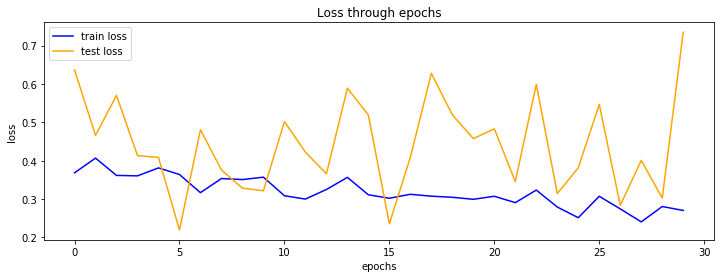

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(train_loss_list, c="blue", label="train loss")
plt.plot(test_loss_list, c="orange", label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss through epochs")
plt.legend()
plt.show()

In [18]:
def test():

    train_loss_list = []
    test_loss_list = []
    
    for x_batch, y_batch, adv_batch in iter(test_dloader):
        test_step(x_batch, y_batch, adv_batch, include_clean=False)

    test_loss = test_losses.result()
    test_acc = test_metrics.result()

    test_loss_list.append(test_loss)

    test_losses.reset_states()
    test_metrics.reset_states()

    print(f"test loss: {test_loss:.8f}, test acc: {test_acc:.4f}")


In [21]:
test()

test loss: 1.04596090, test acc: 0.7305
